# Assignment 2: Machine Learning Project
## Project 1: Classify Images of Colon Cancer
### By Julian Schmidt-Heron (ID: s4002485) and Swayam Mayankkumar Patel (ID: s3994439)

### 1.1 Data Exploration and Understanding

#### Class Imbalance Identification

In [1]:
#First import the nesesary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# And also set consistent plot style
sns.set(style="whitegrid")

#disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Load the dataset CSVs
# Define paths
main_data_path = "Image_classification_data/data_labels_mainData.csv"
extra_data_path = "Image_classification_data/data_labels_extraData.csv"

# Load CSVs into pandas DataFrames
main_df = pd.read_csv(main_data_path)
extra_df = pd.read_csv(extra_data_path)

# Have a quick preview of the datasets
print("Main Data:")
print(main_df.head())
print("\nExtra Data:")
print(extra_df.head())

Main Data:
   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

Extra Data:
   InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0


##### Task 1

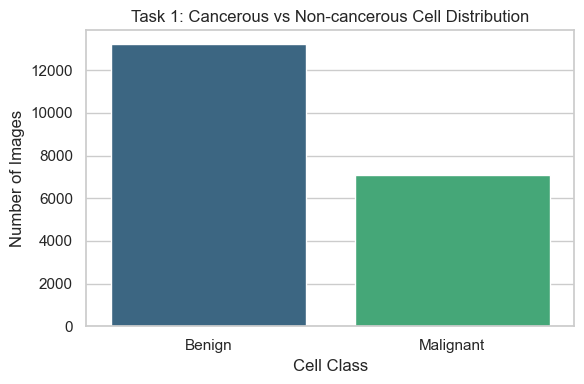

Task 1 - Cancerous Class Distribution:
isCancerous
Benign       13211
Malignant     7069
Name: count, dtype: int64


In [3]:
# ForTask 1, we will have a look at the Class Distribution of Cancerous vs Non-cancerous Cells

# Task 1 is "isCancerous", available in both main and extra data
# We'll concatenate the two datasets for a full view
combined_df_task1 = pd.concat([main_df[['isCancerous']], extra_df[['isCancerous']]])

# Count the number of samples per class
task1_counts = combined_df_task1['isCancerous'].value_counts().sort_index()

# Map labels for better visualization
task1_labels = {0: 'Benign', 1: 'Malignant'}

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=[task1_labels[i] for i in task1_counts.index], y=task1_counts.values, palette="viridis")
plt.title('Task 1: Cancerous vs Non-cancerous Cell Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Cell Class')
plt.tight_layout()
plt.show()

# Display actual numbers
print("Task 1 - Cancerous Class Distribution:")
print(task1_counts.rename(index=task1_labels))

In [4]:
# Calculate class imbalance ratio for Task 1
benign = task1_counts[0]
malignant = task1_counts[1]
imbalance_ratio = round(max(benign, malignant) / min(benign, malignant), 2)

# Printing out the values with their names
print(f"Task 1 Imbalance Ratio (isCancerous):: {imbalance_ratio}")


Task 1 Imbalance Ratio (isCancerous):: 1.87


•For our task 1 data, we can see that there is a class inbalance of 1.87, meaning that Benign instances appear 1.87 times more often than Malignant instances. We can see that Benign appears 13211 times, and Malignant appears 7069 times, with Benign being almost twice as prevelent as Malignant. This imbalance can bias the model toward the majority class during training, so we will later apply balancing techniques such as class weighting or augmentation to help the model learn to classify both classes more effectively.


##### Task 1

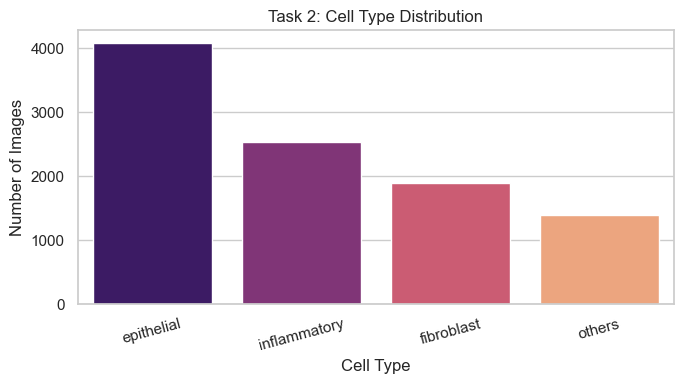

Task 2 - Cell Type Distribution:
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64


In [5]:
# ForTask 2, we will have a look at the Class Distribution of Cell Type  (only in main_df)

# Task 2 is "cellTypeName", only available in the main data (first 60 patients)
task2_counts = main_df['cellTypeName'].value_counts()

# Plot
plt.figure(figsize=(7, 4))
sns.barplot(x=task2_counts.index, y=task2_counts.values, palette="magma")
plt.title('Task 2: Cell Type Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Cell Type')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Display actual numbers
print("Task 2 - Cell Type Distribution:")
print(task2_counts)

In [6]:
# Calculate class imbalance ratio for Task 2 (Cell Type)
# Count the occurrences of each class (cell type) in Task 2
task2_counts = main_df['cellTypeName'].value_counts()

# Get counts for each class
fibroblast = task2_counts.get('fibroblast', 0)
inflammatory = task2_counts.get('inflammatory', 0)
epithelial = task2_counts.get('epithelial', 0)
others = task2_counts.get('others', 0)

# Calculate imbalance ratio (max/min)
task2_imbalance_ratio = round(max(fibroblast, inflammatory, epithelial, others) / min(fibroblast, inflammatory, epithelial, others), 2)

# Print the imbalance ratio
print(f"Task 2 Imbalance Ratio (Cell Type): {task2_imbalance_ratio}")


Task 2 Imbalance Ratio (Cell Type): 2.94


•For our task 2 data (Cell Type Classification), we can see that there is a class imbalance ratio of 2.94, meaning that Epithelial instances appear 2.94 times more often than Others. Specifically, Epithelial appears 4,079 times, Inflammatory appears 2,543 times, Fibroblast appears 1,888 times and Others appears 1,386 times. This imbalance can bias the model toward the majority class (Epithelial), so we will apply techniques such as class weighting or augmentation to balance the training process.